# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [383]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [384]:
# Load the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')


In [385]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).
print("General demographics data - Shape:", azdias.shape)
print("First few rows of general demographics data:")
azdias.head()

General demographics data - Shape: (891221, 85)
First few rows of general demographics data:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [386]:
print("Feature summary - Shape:", feat_info.shape)
print("First few rows of feature summary:")
feat_info.head()

Feature summary - Shape: (85, 4)
First few rows of feature summary:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [387]:
# Function to convert missing value codes to NaNs
def convert_missing_to_nan(df, feat_info):
    for idx, row in feat_info.iterrows():
        missing_or_unknown = row['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[').strip(']').split(',')
        for code in missing_or_unknown:
            try:
                code = int(code)
            except ValueError:
                pass
            df[row['attribute']] = df[row['attribute']].replace(code, np.nan)
    return df

In [388]:
# Convert missing value codes to NaNs in the demographics data
azdias = convert_missing_to_nan(azdias, feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [389]:
# Perform an assessment of how much missing data there is in each column of the dataset.
def extract_columns_with_nan(df):
    columns_with_nans = df.isnull().sum()    
    columns_with_nans = columns_with_nans[columns_with_nans > 0]
    nan_percentages = np.round(columns_with_nans * 100 / len(df), 2)
    df_nan = pd.DataFrame({'NaN_Count': columns_with_nans, 'NaN_Percentage': nan_percentages})
    df_nan = df_nan.sort_values(by='NaN_Percentage', ascending=False)
    return df_nan

In [390]:
azdias_nan = extract_columns_with_nan(azdias)
azdias_nan

,NaN_Count,NaN_Percentage
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG3,133324,14.96


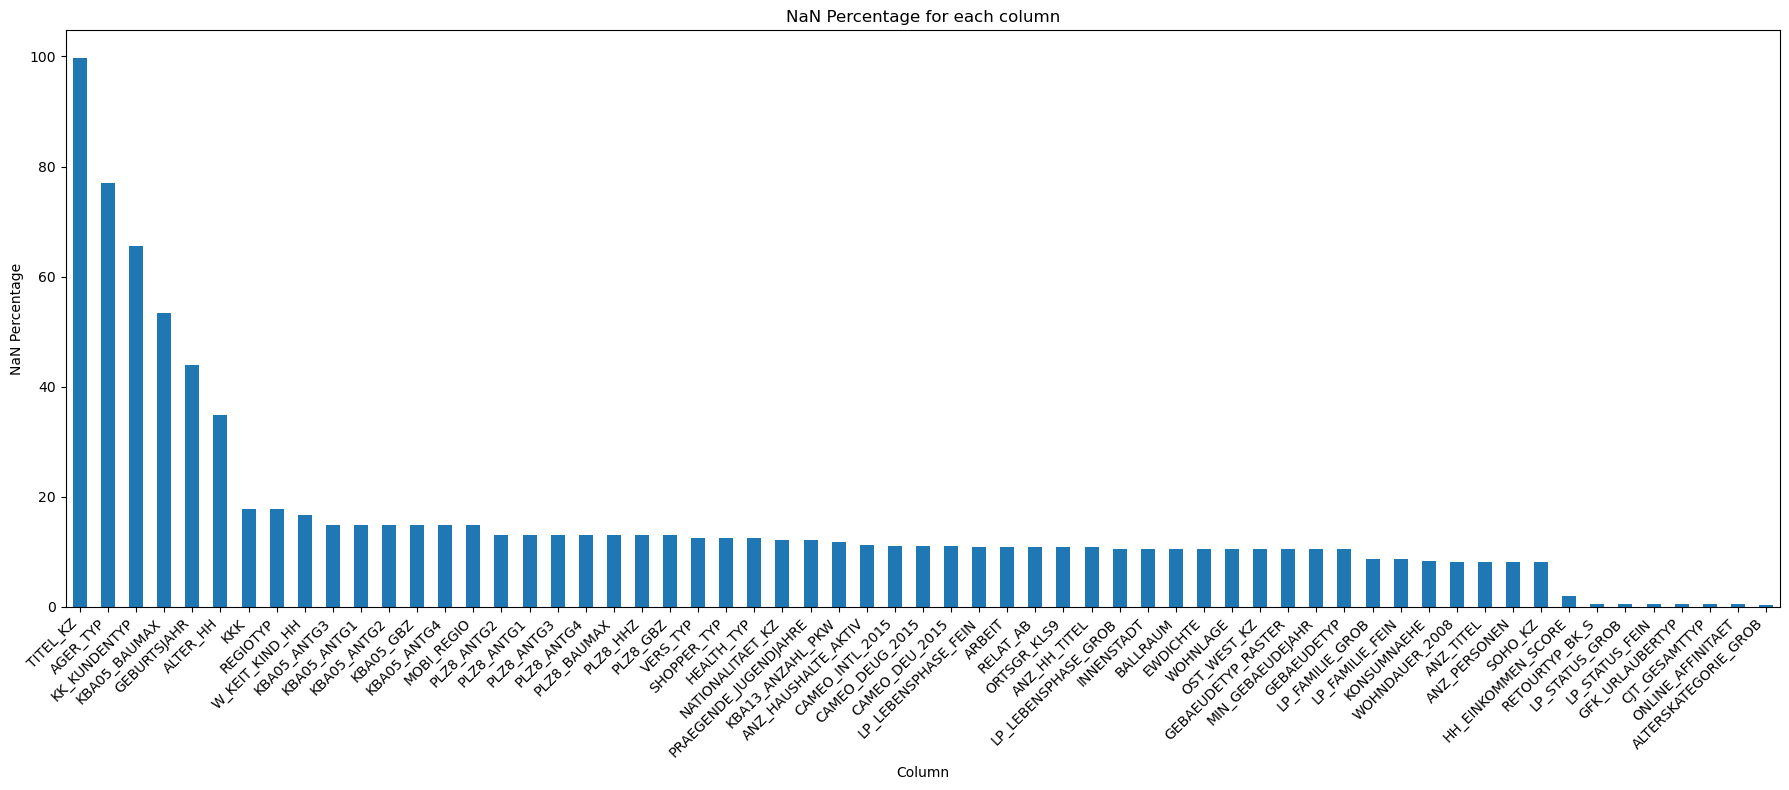

In [391]:
# Investigate patterns in the amount of missing data in each column.

# Plot the bar plot of missing percentage for each column
plt.figure(figsize=(18, 8))
bar_plot = azdias_nan['NaN_Percentage'].plot.bar()

plt.xlabel('Column')
plt.ylabel('NaN Percentage')
plt.title('NaN Percentage for each column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [392]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)

# Threshold for identifying outlier columns
threshold = 30 

outlier_columns = azdias_nan[azdias_nan['NaN_Percentage'] > threshold].index.tolist()
azdias.drop(outlier_columns, axis=1, inplace=True)
feat_info = feat_info[~feat_info.attribute.isin(outlier_columns)]

print("Columns removed:", outlier_columns)

Columns removed: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [393]:
print("Shape of the cleaned dataset after removing outlier columns:", azdias.shape)

Shape of the cleaned dataset after removing outlier columns: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column
The dataset exhibits a wide range of columns with less than 20% of missing values.
Few columns have a disproportionately high percentage of missing values.
Columns with over 30% missing values were considered outliers and removed.

Columns Removed:

- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [394]:
# Calculate the number of missing values in each row
missing_values_per_row = azdias.isnull().sum(axis=1)

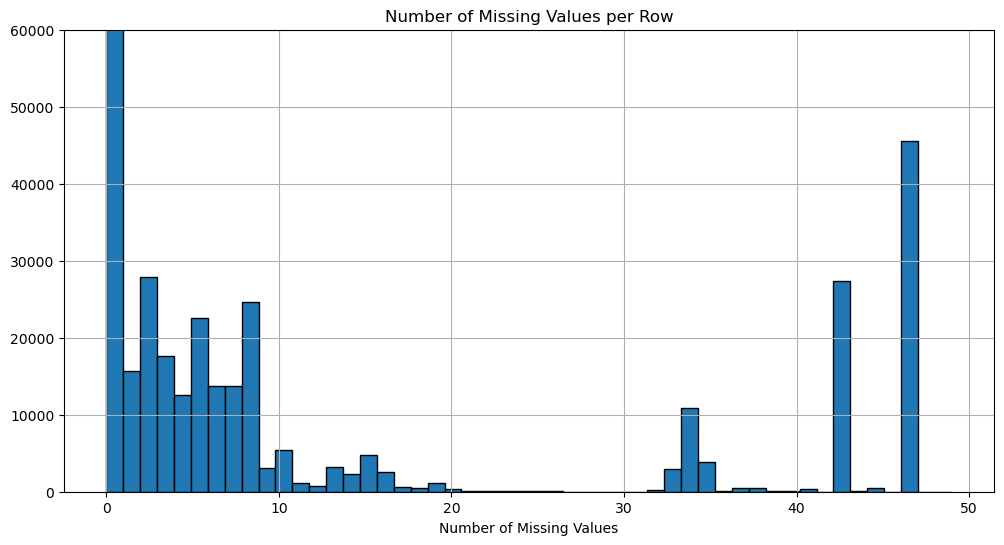

In [395]:
plt.figure(figsize=(12, 6))
plt.hist(missing_values_per_row, bins=50, edgecolor='black')
plt.title('Number of Missing Values per Row')
plt.xlabel('Number of Missing Values')
plt.ylim(0, 60000)  # Adjust the range of y-axis as per your preference
plt.grid(True)
plt.show()

In [396]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
threshold = 20

subset_with_many_missing = azdias[missing_values_per_row > threshold]
subset_with_few_missing = azdias[missing_values_per_row <= threshold]  # Subset with 2 or fewer missing values

In [397]:
def compare_distribution(column, subset_with_many_missing, subset_with_few_missing):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    sns.countplot(x=column, data=subset_with_few_missing)
    plt.title('Subset with few or no missing values')

    plt.subplot(1, 2, 2)
    sns.countplot(x=column, data=subset_with_many_missing)
    plt.title('Subset with many missing values')

    plt.tight_layout()
    plt.show()

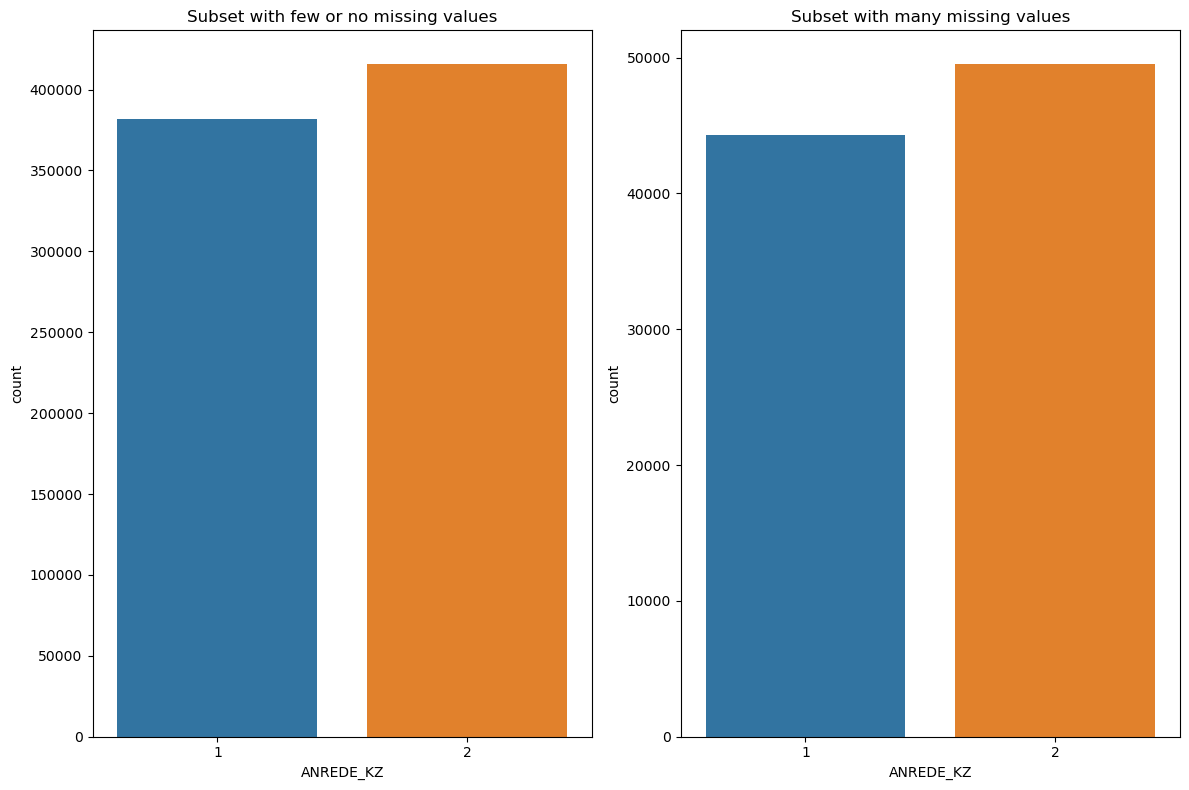

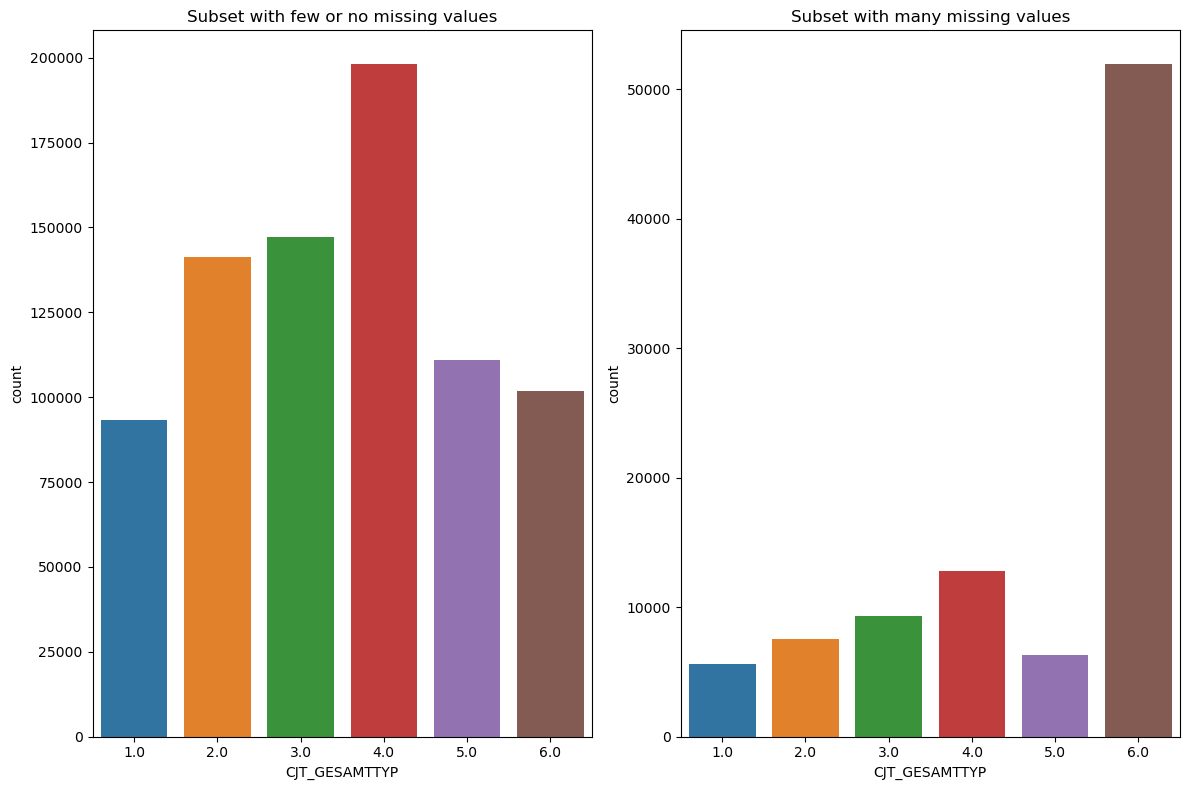

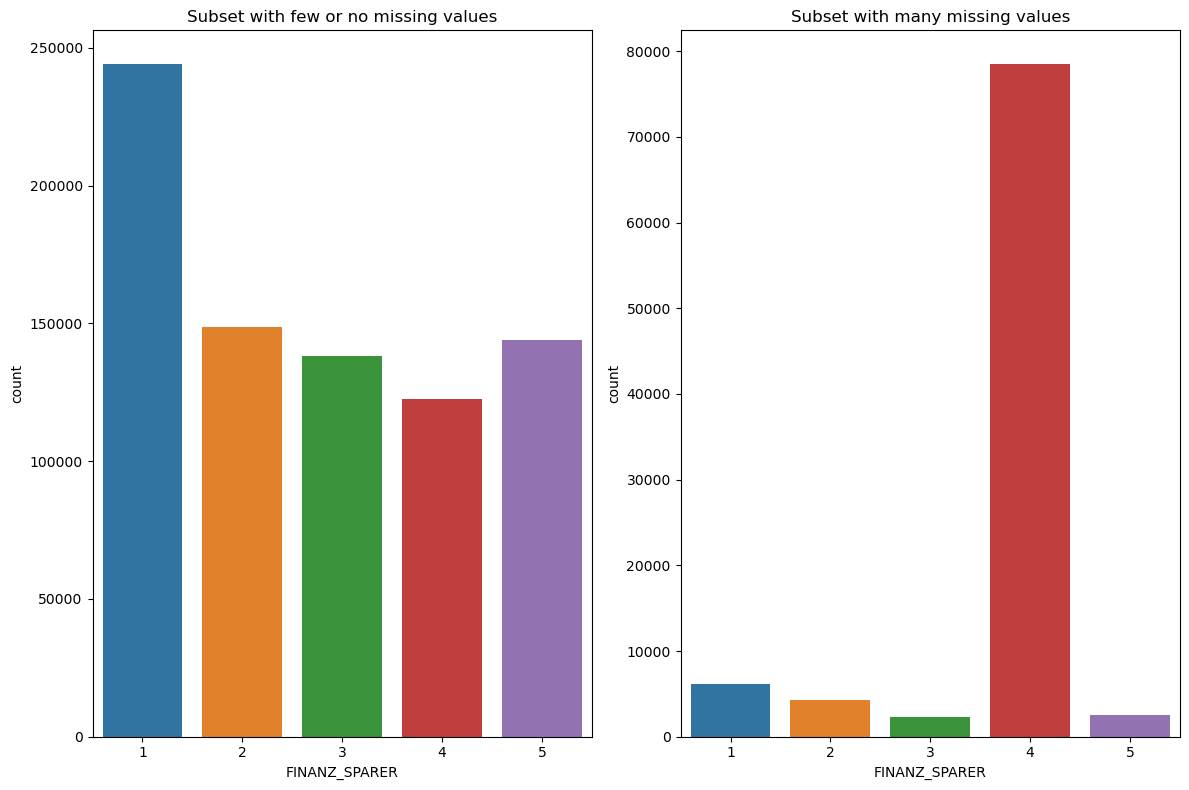

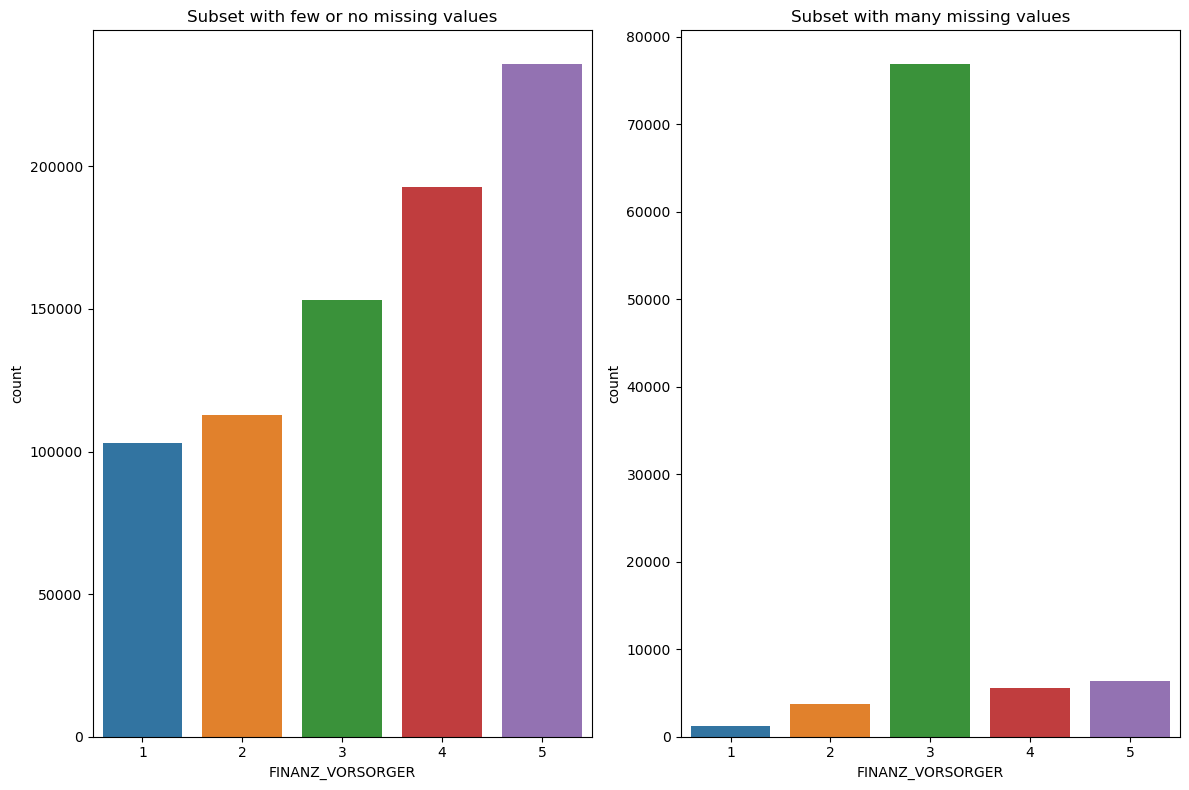

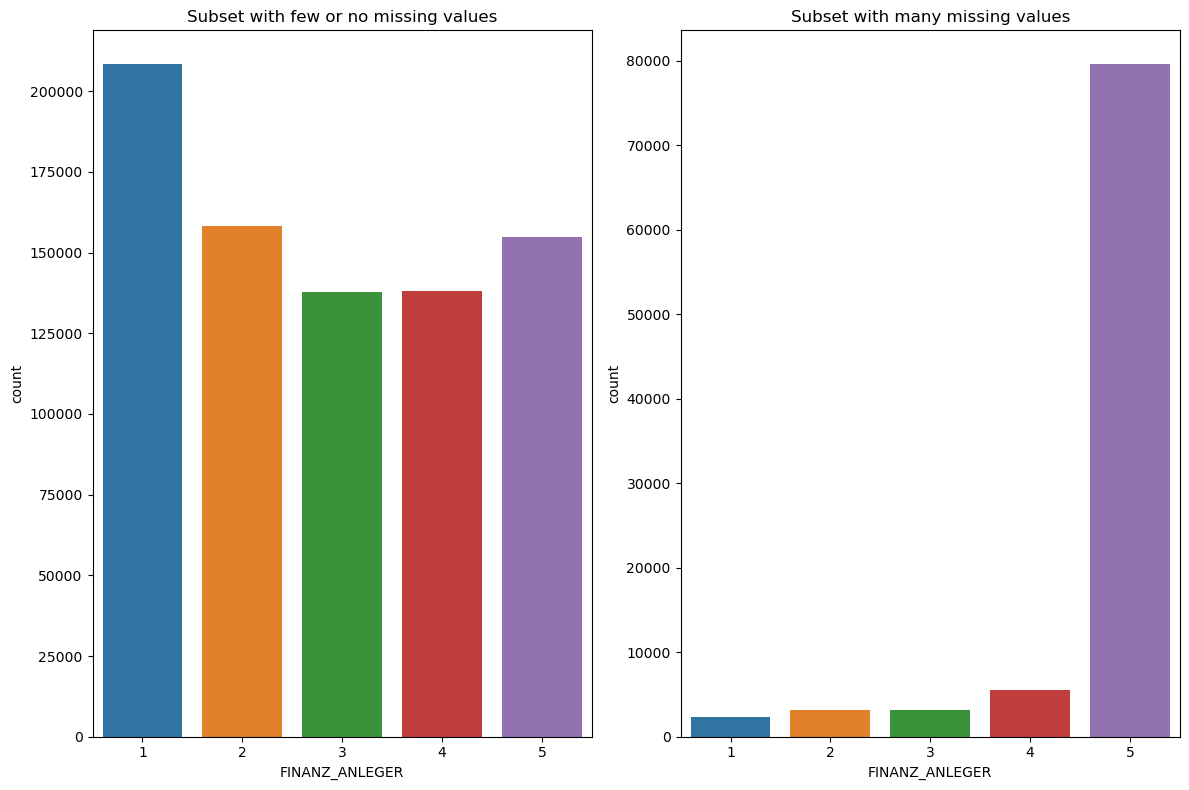

In [398]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
columns_to_compare_indexes = missing_values_per_row.nsmallest(5).index

for i in columns_to_compare_indexes:
    compare_distribution(azdias.columns[i], subset_with_many_missing, subset_with_few_missing)

#### Discussion 1.1.3: Assess Missing Data in Each Row

We observe a qualitative difference between datasets with abundant missing values and those with few or none. This distinction is particularly evident when examining the first five columns that contain no missing data. Therefore, it's essential to recognize the unique nature of these datasets when evaluating the missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [399]:
# How many features are there of each data type?
feat_info.type.value_counts()

type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [400]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info[feat_info.type == 'categorical'].attribute
categorical_features

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [401]:
categorical_binary = [feature for feature in categorical_features if azdias[feature].nunique() <= 2]
categorical_multi = [feature for feature in categorical_features if azdias[feature].nunique() > 2]

In [402]:
for col in categorical_binary:
    print(azdias[col].value_counts())

ANREDE_KZ
2    465305
1    425916
Name: count, dtype: int64
GREEN_AVANTGARDE
0    715996
1    175225
Name: count, dtype: int64
SOHO_KZ
0.0    810834
1.0      6888
Name: count, dtype: int64
VERS_TYP
2.0    398722
1.0    381303
Name: count, dtype: int64
OST_WEST_KZ
W    629528
O    168545
Name: count, dtype: int64


In [403]:
#These need to be re-ecnoded
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

In [404]:
# Do one-hot-encoding for categorical_multi
azdias = pd.get_dummies(azdias, columns=categorical_multi)

#### Discussion 1.2.1: Re-Encode Categorical Features

The dataset possess only 5 binary features in total, with one exception being non-numeric. 
However, the majority of our categorical attributes present themselves as multilevel categories.

To address this, I've retained all numeric binary categorical variables while transforming the non-numeric binary ones. Specifically, I've reassigned 'W' as 0 and 'O' as 1. Additionally, I've utilized dummy variables to re-encode the multilevel features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [405]:
mixed_features = feat_info[feat_info.type == 'mixed'].attribute
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [406]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

mainstream = [1, 3, 5, 8, 10, 12, 14]

# Create movement variable (binary)
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream else 0)

# Create decade variable (interval-type)
decade_mapping ={1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)

In [407]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Assign 'CAMEO_INTL_2015' to 'WEALTH' and 'LIFE_STAGE'
azdias['WEALTH'] = azdias['CAMEO_INTL_2015']
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015']

# Convert 'WEALTH' to integer, preserving NaN values
azdias['WEALTH'] = azdias['WEALTH'].apply(lambda x: x if pd.isnull(x) else int(x[1]))

# Convert 'LIFE_STAGE' to integer, preserving NaN values
azdias['LIFE_STAGE'] = azdias['LIFE_STAGE'].apply(lambda x: x if pd.isnull(x) else int(x[0]))

In [408]:
other_mixed_to_drop = ['KKK', 'REGIOTYP', 'GEBAEUDETYP_5.0']
for col in other_mixed_to_drop:
    if col in azdias.columns:
        azdias.drop(col, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

In the dataset, there were six attributes with mixed types. After looking into them closely, I made four new attributes: two to understand PRAEGENDE_JUGENDJAHRE and two more for CAMEO_INTL_2015.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [409]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [410]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias = azdias.drop(columns=mixed_features , axis=1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,WEALTH,LIFE_STAGE
0,2.0,0,3,4,3,5,5,3,0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [411]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    df = convert_missing_to_nan(df, feat_info)           

    df_nan = extract_columns_with_nan(df)

    threshold = 30 
    
    outlier_columns = df_nan[df_nan['NaN_Percentage'] > threshold].index.tolist()
    df.drop(outlier_columns, axis=1, inplace=True)
    feat_info = feat_info[~feat_info.attribute.isin(outlier_columns)]

    missing_values_per_row = df.isnull().sum(axis=1)

    threshold = 20
    subset_with_many_missing = df[missing_values_per_row > threshold]
    subset_with_few_missing = df[missing_values_per_row <= threshold]

    categorical_features = feat_info[feat_info.type == 'categorical'].attribute

    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    categorical_multi = [feature for feature in categorical_features if df[feature].nunique() > 2]

    df = pd.get_dummies(df, columns=categorical_multi)
    
    mixed_features = feat_info[feat_info.type == 'mixed'].attribute

    mainstream = [1, 3, 5, 8, 10, 12, 14]

    # Create movement variable (binary)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream else 0)
    
    # Create decade variable (interval-type)
    decade_mapping ={1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)
    
    # Assign 'CAMEO_INTL_2015' to 'WEALTH' and 'LIFE_STAGE'
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    
    # Convert 'WEALTH' to integer, preserving NaN values
    df['WEALTH'] = df['WEALTH'].apply(lambda x: x if pd.isnull(x) else int(x[1]))
    
    # Convert 'LIFE_STAGE' to integer, preserving NaN values
    df['LIFE_STAGE'] = df['LIFE_STAGE'].apply(lambda x: x if pd.isnull(x) else int(x[0]))
    
    df = df.drop(columns=mixed_features , axis=1)

    other_mixed_to_drop = ['KKK', 'REGIOTYP', 'GEBAEUDETYP_5.0']
    for col in other_mixed_to_drop:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
            
    return df

In [412]:
# TEST
# Load in the general demographics data.
azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info_test = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

azdias_test = clean_data(azdias_test, feat_info_test)
assert azdias_test.shape[0] == azdias.shape[0], "clean_data function is not working properly, rows mismatch"
assert azdias_test.shape[1] == azdias.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [413]:
imputer = SimpleImputer(strategy='most_frequent')
number_of_nan = azdias.isnull().any().sum()
print("Number of NaN in the dataset: ", number_of_nan)

if number_of_nan > 0:
    column_names = azdias.columns
    azdias = imputer.fit_transform(azdias)
    azdias = pd.DataFrame(azdias, columns=column_names)
    print("Number of NaN in the dataset after Imputer processing: ", azdias.isnull().any().sum())

Number of NaN in the dataset:  39
Number of NaN in the dataset after Imputer processing:  0


In [414]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias)
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias.columns)

### Discussion 2.1: Apply Feature Scaling

I've replaced the NaN values in each feature using the Imputer instance.
Additionally, every feature has been standardized to have a mean of 0 and a standard deviation of 1 using the StandardScaler instance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [415]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(azdias_scaled)

array([[ 2.34687121e+00, -1.14420788e+00, -4.23420055e+00, ...,
        -5.66463957e-15, -8.10488153e-15,  3.09039717e-15],
       [ 5.22360112e+00, -3.22082618e+00, -2.94010842e-01, ...,
        -3.49483455e-14, -9.53625260e-15,  2.09228258e-16],
       [-3.53851255e-01, -5.82073370e-01, -1.65699128e+00, ...,
         9.85600297e-15,  3.12019356e-15, -1.73420403e-15],
       ...,
       [-8.43295258e-01, -3.69396056e+00, -1.58885528e-01, ...,
         3.29275877e-17,  7.21682724e-17, -4.55310290e-18],
       [ 6.17154106e+00, -3.02675571e+00,  4.50609869e+00, ...,
         5.22101722e-17,  7.77978601e-17,  2.78539873e-17],
       [-1.10375471e-01,  3.28334974e+00,  2.61051254e+00, ...,
         1.24915895e-16, -1.07331681e-16, -3.44901797e-17]])

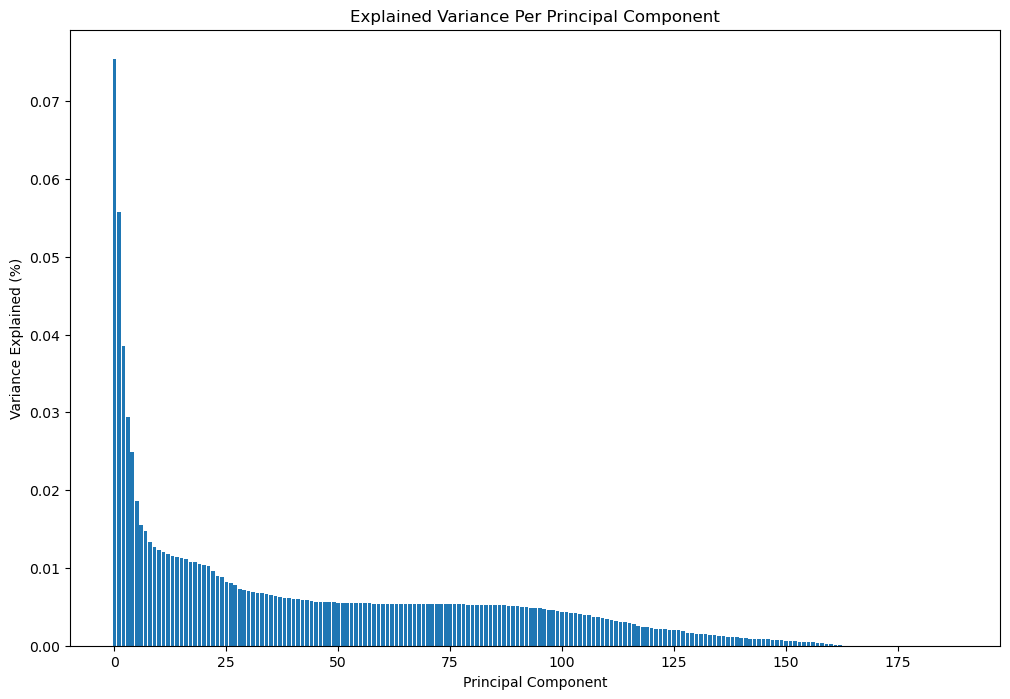

In [376]:
# Investigate the variance accounted for by each principal component.

components = np.arange(azdias_scaled.shape[1])
exp_variance = pca.explained_variance_ratio_
plt.figure(figsize=(12, 8))
plt.bar(components, exp_variance)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance Per Principal Component");

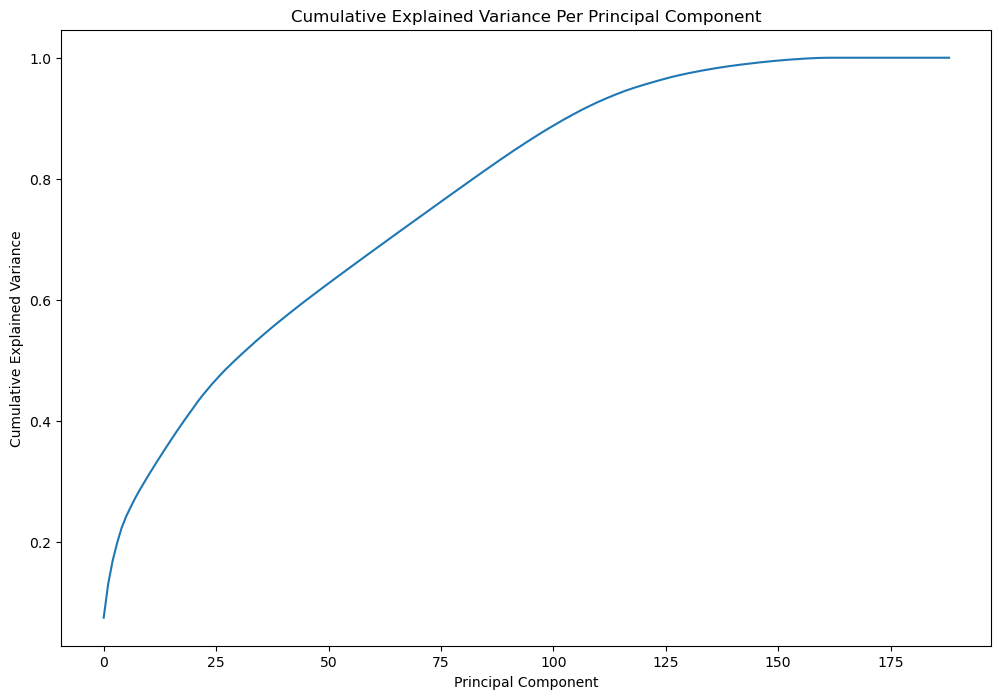

In [377]:
cum_vals = np.cumsum(exp_variance)
plt.figure(figsize=(12, 8))
plt.plot(components, cum_vals)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Per Principal Component");

In [378]:
print('Cumulative Explained Variance:', pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 1.0


In [416]:
# Re-apply PCA to the data while selecting for number of components to retain.
number_of_components = azdias_scaled.shape[1] // 2 #The half of the components
pca = PCA(n_components = number_of_components)
azdias_pca = pca.fit_transform(azdias_scaled)
print('Cumulative Explained Variance with half of the original number of components:', pca.explained_variance_ratio_.sum())

Cumulative Explained Variance with half of the original number of components: 0.852607190224551


### Discussion 2.2: Perform Dimensionality Reduction

With the half of the original components I've managed to explain approximately 85% of the cumulative variance present in the original dataset.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [417]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(dataframe, pca_model, component_number, top_features, display_plot=True):
    pca_components = pd.DataFrame(np.round(pca_model.components_, 4), columns=dataframe.keys()).iloc[component_number - 1]
    pca_components.sort_values(ascending=False, inplace=True)
    pca_components = pd.concat([pca_components.head(top_features), pca_components.tail(top_features)])
    
    if display_plot:
        plt.figure(figsize=(12, 6))
        pca_components.plot(kind='bar', 
                            title='Top {} weighted features for PCA component {}'.format(top_features*2, component_number))
        plt.show()
    
    return pca_components

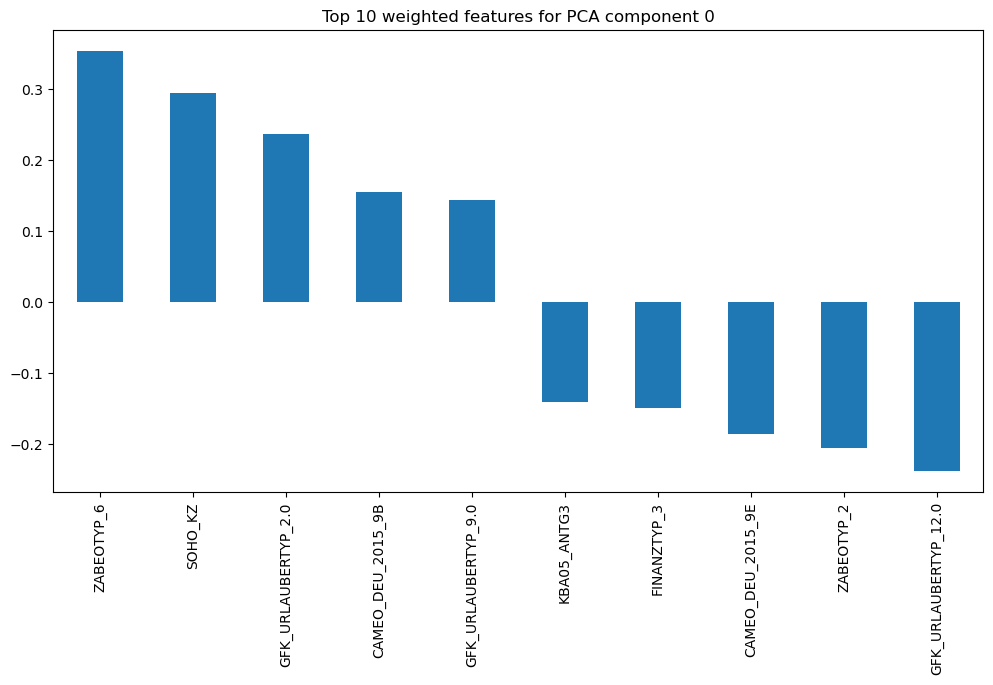

ZABEOTYP_6              0.3539
SOHO_KZ                 0.2950
GFK_URLAUBERTYP_2.0     0.2366
CAMEO_DEU_2015_9B       0.1551
GFK_URLAUBERTYP_9.0     0.1432
KBA05_ANTG3            -0.1402
FINANZTYP_3            -0.1490
CAMEO_DEU_2015_9E      -0.1853
ZABEOTYP_2             -0.2054
GFK_URLAUBERTYP_12.0   -0.2377
Name: 93, dtype: float64


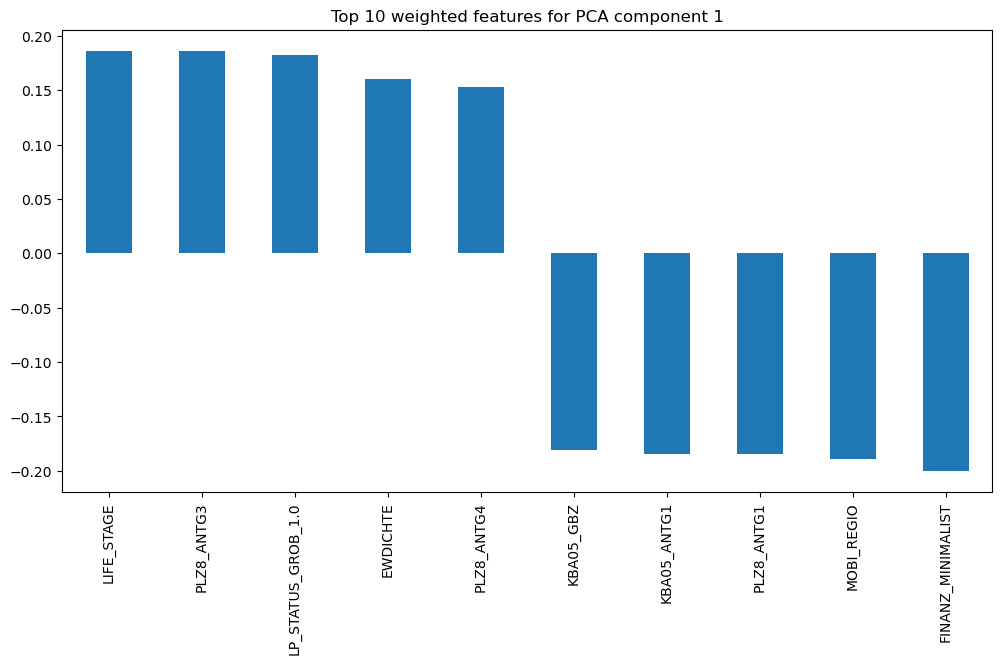

LIFE_STAGE            0.1863
PLZ8_ANTG3            0.1857
LP_STATUS_GROB_1.0    0.1827
EWDICHTE              0.1598
PLZ8_ANTG4            0.1531
KBA05_GBZ            -0.1809
KBA05_ANTG1          -0.1842
PLZ8_ANTG1           -0.1850
MOBI_REGIO           -0.1896
FINANZ_MINIMALIST    -0.1999
Name: 0, dtype: float64


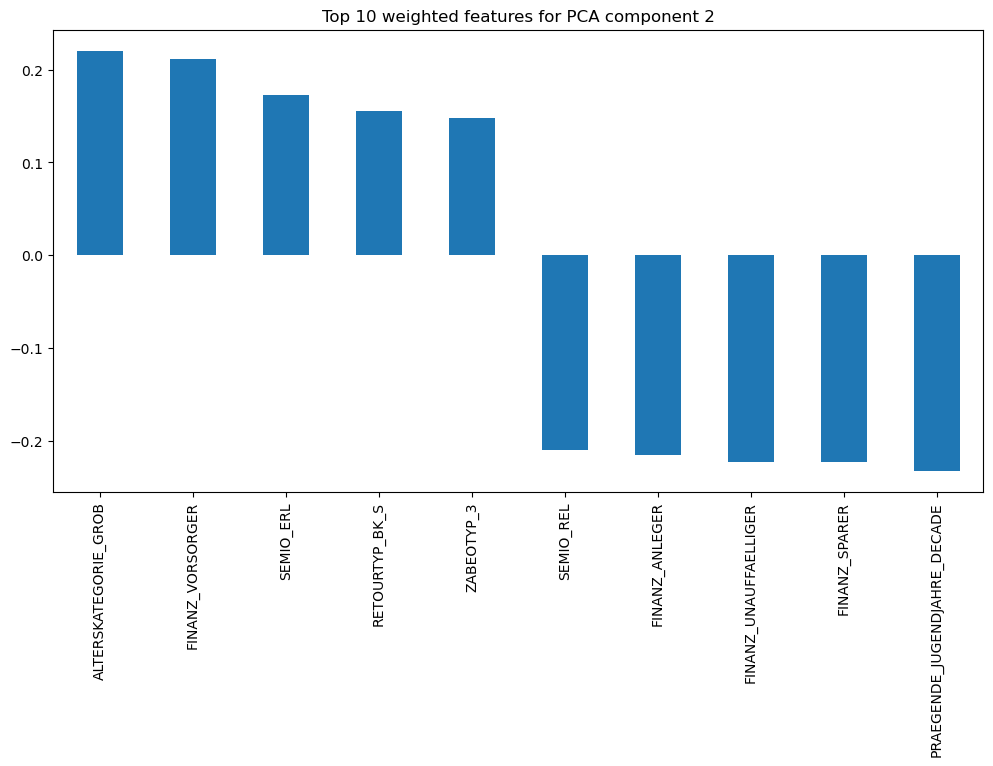

ALTERSKATEGORIE_GROB            0.2203
FINANZ_VORSORGER                0.2118
SEMIO_ERL                       0.1729
RETOURTYP_BK_S                  0.1555
ZABEOTYP_3                      0.1480
SEMIO_REL                      -0.2092
FINANZ_ANLEGER                 -0.2150
FINANZ_UNAUFFAELLIGER          -0.2221
FINANZ_SPARER                  -0.2228
PRAEGENDE_JUGENDJAHRE_DECADE   -0.2318
Name: 1, dtype: float64


In [418]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

for i in np.arange(0, 3, 1):
    res = pca_results(azdias_scaled, pca, i, 5)
    print(res)

### Discussion 2.3: Interpret Principal Components

The main features of each principal component are as follows:

1. **First Component**: Primarily focus on aspects such as shopping habits (SHOPPER_TYP_0.0), home office setup (SOHO_KZ), consumer type (ZABEOTYP_6), nationality (NATIONALITAET_KZ_2.0), and lifestyle (CAMEO_DEU_2015_9D), while also accounting for vacation preferences (GFK_URLAUBERTYP_4.0), indicating a potential correlation with positive shopping behavior and preferences for a home office setup.
   
2. **Second Component**: Primarily focus on aspects such as life stage (LIFE_STAGE), neighborhood density (EWDICHTE), household size (PLZ8_ANTG3), and social status (LP_STATUS_GROB_1.0), indicating potential correlations with residential preferences and financial behavior. Additionally, it considers factors like car ownership (KBA05_ANTG1), mobility (MOBI_REGIO), and financial conservatism (FINANZ_MINIMALIST), suggesting a potential link between lower financial conservatism and higher mobility.
   
3. **Third Component**: Primarily focus on demographic characteristics such as age category (ALTERSKATEGORIE_GROB) and financial attitudes like financial preparedness (FINANZ_VORSORGER) and investment behavior (FINANZ_ANLEGER). Additionally, it considers psychographic attributes such as event-oriented personality (SEMIO_ERL) and religious affinity (SEMIO_REL), indicating potential correlations with consumer behavior and lifestyle preferences.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [186]:
from sklearn.cluster import MiniBatchKMeans

sse = []
k_range = list(range(2, 21))

for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=100, n_init=10, random_state=42).fit(azdias_pca)
    score = np.abs(kmeans.score(azdias_pca))
    sse.append(score)
    print('Clustering done for {} clusters -> SSE {:.2f}'.format(k, score))

Clustering done for 2 clusters -> SSE 133974924.25
Clustering done for 3 clusters -> SSE 133176004.89
Clustering done for 4 clusters -> SSE 125093864.48
Clustering done for 5 clusters -> SSE 122256175.28
Clustering done for 6 clusters -> SSE 121040468.67
Clustering done for 7 clusters -> SSE 117623025.81
Clustering done for 8 clusters -> SSE 117034970.46
Clustering done for 9 clusters -> SSE 118825299.24
Clustering done for 10 clusters -> SSE 115463582.37
Clustering done for 11 clusters -> SSE 115238051.80
Clustering done for 12 clusters -> SSE 111661049.80
Clustering done for 13 clusters -> SSE 112034114.07
Clustering done for 14 clusters -> SSE 111207329.98
Clustering done for 15 clusters -> SSE 111868866.35
Clustering done for 16 clusters -> SSE 108936688.79
Clustering done for 17 clusters -> SSE 110250867.76
Clustering done for 18 clusters -> SSE 108259421.90
Clustering done for 19 clusters -> SSE 107943920.35
Clustering done for 20 clusters -> SSE 107553832.71


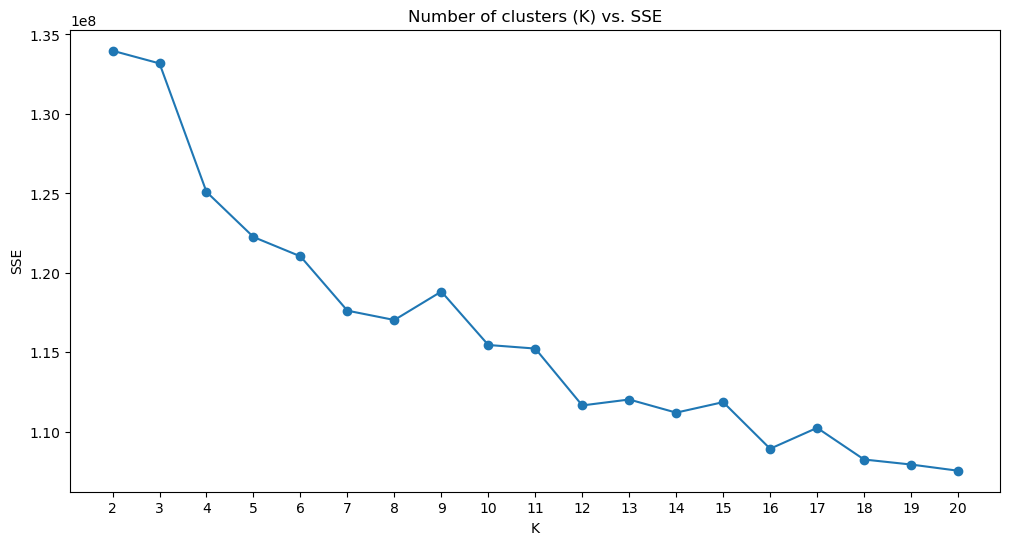

In [187]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12, 6))
plt.title('Number of clusters (K) vs. SSE')
plt.xlabel('K')
plt.xticks(k_range)
plt.ylabel('SSE')
plt.plot(k_range, sse, linestyle='-', marker='o');

In [419]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 16
kmeans = KMeans(n_clusters=k, n_init=10).fit(azdias_pca)
population_clusters = kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

The plot shows a more pronounced elbow trend beyond K = 16. Consequently, 16 is determined as the optimal number of clusters for the entire dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [428]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info_customers = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [429]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers, feat_info_customers)

number_of_nan = customers_cleaned.isnull().any().sum()

print("Number of NaN in the dataset: ", number_of_nan)

if number_of_nan > 0:
    column_names = customers_cleaned.columns
    customers_cleaned = imputer.transform(customers_cleaned)
    customers_cleaned = pd.DataFrame(customers_cleaned, columns=column_names)
    print("Number of NaN in the dataset after Imputer processing: ", customers_cleaned.isnull().any().sum())

Number of NaN in the dataset:  39
Number of NaN in the dataset after Imputer processing:  0


In [430]:
customers_scaled = scaler.transform(customers_cleaned)
customers_scaled = pd.DataFrame(customers_scaled, columns=customers_cleaned.columns)

In [431]:
customers_pca = pca.transform(customers_scaled)

In [432]:
customer_clusters = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

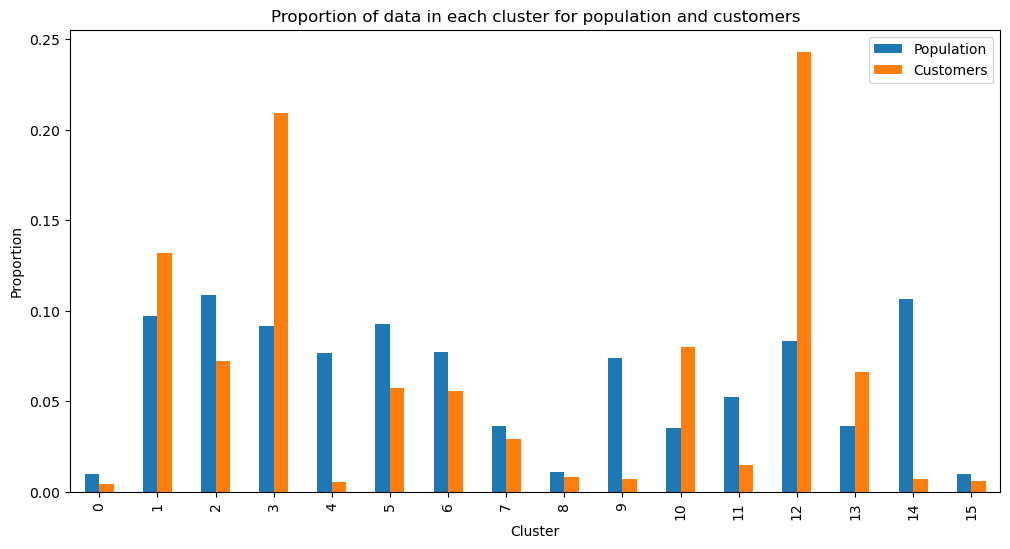

In [433]:
pop_clusters_count = pd.Series(population_clusters).value_counts().sort_index()
cust_clusters_count = pd.Series(customer_clusters).value_counts().sort_index()

pop_cust_summary = pd.concat([pop_clusters_count, cust_clusters_count], axis=1).reset_index()
pop_cust_summary.columns = ['cluster', 'population', 'customers']

pop_cust_summary['cust_prop'] = pop_cust_summary['customers'] / pop_cust_summary['customers'].sum()
pop_cust_summary['pop_prop'] = pop_cust_summary['population'] / pop_cust_summary['population'].sum()

pop_cust_summary.plot(x='cluster', y=['pop_prop', 'cust_prop'], kind='bar', figsize=(12, 6))
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Proportion of data in each cluster for population and customers')
plt.legend(['Population', 'Customers'])
plt.show()

In [434]:
centroid_cluster_12 = kmeans.cluster_centers_[12]
centroid_cluster_12 = pd.Series(centroid_cluster_12)
centroid_cluster_12.sort_values(ascending=False, inplace=True)
centroid_cluster_12.head(5)

0     2.196351
5     0.967001
21    0.210363
17    0.205643
6     0.205311
dtype: float64

In [435]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_cluster_12 = kmeans.cluster_centers_[12]
centroid_original_12 = pca.inverse_transform([centroid_cluster_12])
centroid_original_12 = scaler.inverse_transform(centroid_original_12)

centroid_series_12 = pd.Series(centroid_original_12.flatten(), index=customers_cleaned.columns)
centroid_series_12

ALTERSKATEGORIE_GROB                 2.337274
ANREDE_KZ                            0.559018
FINANZ_MINIMALIST                    3.011046
FINANZ_SPARER                        4.018927
FINANZ_VORSORGER                     2.931559
FINANZ_ANLEGER                       5.006596
FINANZ_UNAUFFAELLIGER                5.037498
FINANZ_HAUSBAUER                     2.889152
GREEN_AVANTGARDE                     0.025666
HEALTH_TYP                           3.025480
RETOURTYP_BK_S                       3.314817
SEMIO_SOZ                            1.996718
SEMIO_FAM                            5.900132
SEMIO_REL                            6.944071
SEMIO_MAT                            5.053501
SEMIO_VERT                           1.157597
SEMIO_LUST                           5.026922
SEMIO_ERL                            3.105894
SEMIO_KULT                           3.045378
SEMIO_RAT                            4.109044
SEMIO_KRIT                           6.972234
SEMIO_DOM                         

In [438]:
pca_results(customers_cleaned, pca, component_number=0, top_features=5, display_plot=False)

ZABEOTYP_6              0.3539
SOHO_KZ                 0.2950
GFK_URLAUBERTYP_2.0     0.2366
CAMEO_DEU_2015_9B       0.1551
GFK_URLAUBERTYP_9.0     0.1432
KBA05_ANTG3            -0.1402
FINANZTYP_3            -0.1490
CAMEO_DEU_2015_9E      -0.1853
ZABEOTYP_2             -0.2054
GFK_URLAUBERTYP_12.0   -0.2377
Name: 93, dtype: float64

In [439]:
pca_results(customers_cleaned, pca, component_number=5, top_features=5, display_plot=False)

GREEN_AVANTGARDE       0.2592
LP_STATUS_FEIN_10.0    0.2333
LP_STATUS_GROB_5.0     0.2333
ANZ_PERSONEN           0.2197
ORTSGR_KLS9            0.2066
INNENSTADT            -0.1742
BALLRAUM              -0.1827
W_KEIT_KIND_HH        -0.1933
LP_FAMILIE_GROB_1.0   -0.1999
LP_FAMILIE_FEIN_1.0   -0.1999
Name: 4, dtype: float64

In [436]:
centroid_cluster_14 = kmeans.cluster_centers_[14]
centroid_cluster_14 = pd.Series(centroid_cluster_14)
centroid_cluster_14.sort_values(ascending=False, inplace=True)
centroid_cluster_14.head(5)

0     4.920794
3     2.365811
4     0.991353
9     0.393608
25    0.274551
dtype: float64

In [437]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_cluster_14 = kmeans.cluster_centers_[14]
centroid_original_14 = pca.inverse_transform([centroid_cluster_14])
centroid_original_14 = scaler.inverse_transform(centroid_original_14)
centroid_series_14 = pd.Series(centroid_original_14.flatten(), index=customers_cleaned.columns)
centroid_series_14

ALTERSKATEGORIE_GROB                 1.810497
ANREDE_KZ                            0.989077
FINANZ_MINIMALIST                    1.124839
FINANZ_SPARER                        4.453192
FINANZ_VORSORGER                     2.223754
FINANZ_ANLEGER                       4.413550
FINANZ_UNAUFFAELLIGER                3.867413
FINANZ_HAUSBAUER                     4.284204
GREEN_AVANTGARDE                     0.053926
HEALTH_TYP                           2.344803
RETOURTYP_BK_S                       2.576876
SEMIO_SOZ                            3.229450
SEMIO_FAM                            3.907881
SEMIO_REL                            5.299188
SEMIO_MAT                            4.650166
SEMIO_VERT                           2.278132
SEMIO_LUST                           3.221245
SEMIO_ERL                            4.403625
SEMIO_KULT                           3.998085
SEMIO_RAT                            5.904789
SEMIO_KRIT                           5.489209
SEMIO_DOM                         

In [660]:
pca_results(customers_cleaned, pca, component_number=0, top_features=5, display_plot=False)

GFK_URLAUBERTYP_11.0    0.2829
SHOPPER_TYP_0.0         0.2686
GFK_URLAUBERTYP_12.0    0.2220
SOHO_KZ                 0.1956
ANZ_HH_TITEL            0.1665
FINANZTYP_2            -0.1377
SHOPPER_TYP_2.0        -0.1634
GFK_URLAUBERTYP_7.0    -0.2179
GFK_URLAUBERTYP_9.0    -0.2218
GFK_URLAUBERTYP_4.0    -0.2647
Name: 93, dtype: float64

In [661]:
pca_results(customers_cleaned, pca, component_number=3, top_features=5, display_plot=False)

SEMIO_VERT                        0.2952
SEMIO_KULT                        0.2662
SEMIO_SOZ                         0.2595
SEMIO_FAM                         0.1461
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.1297
ZABEOTYP_3                       -0.1777
ANREDE_KZ                        -0.2345
SEMIO_DOM                        -0.2494
SEMIO_KAEM                       -0.2772
SEMIO_KRIT                       -0.2805
Name: 2, dtype: float64

# Discussion 3.3: Compare Customer Data to Demographics Data


#### Overrepresented in customer data (cluster 12):

- GFK_URLAUBERTYP_11.0: This feature represents individuals who prefer vacation activities like cultural and nature-oriented trips.
- SHOPPER_TYP_0.0: Represents non-shoppers or individuals who do not belong to any specific shopping typology.
- GFK_URLAUBERTYP_12.0: Indicates individuals who prefer vacation activities such as camping and hiking.
- SOHO_KZ: Stands for "Small office / Home office," suggesting individuals who operate a business from their home or have a small office setup.
- ANZ_HH_TITEL: Denotes the number of academic titles in a household, suggesting a potentially educated or scholarly demographic.
- GREEN_AVANTGARDE: Indicates whether an individual is part of the environmentally conscious avant-garde.
- LP_STATUS_FEIN_10.0: Represents individuals with a fine-scale social status of "top earners."
- LP_STATUS_GROB_5.0: Indicates individuals with a coarse-scale social status of "top earners."
- ANZ_PERSONEN: Represents the number of people in the household, providing insight into household size.
- ORTSGR_KLS9: Denotes the community size, with higher values indicating larger communities.
  
##### Interpretation

This cluster likely represents a niche group of environmentally conscious, financially well-off individuals who value education and outdoor activities.

#### Underrepresented in customer data (cluster 14):

- GFK_URLAUBERTYP_11.0: Indicates individuals who prefer vacation activities like cultural and nature-oriented trips.
- SHOPPER_TYP_0.0: Represents non-shoppers or individuals who do not belong to any specific shopping typology.
- GFK_URLAUBERTYP_12.0: Represents individuals who prefer vacation activities such as camping and hiking.
- SOHO_KZ: Stands for "Small office / Home office," suggesting individuals who operate a business from their home or have a small office setup.
- ANZ_HH_TITEL: Denotes the number of academic titles in a household, suggesting a potentially educated or scholarly demographic.
- SEMIO_VERT: Reflects personality traits related to dreaminess and fantasy.
- SEMIO_KULT: Reflects personality traits related to cultural-mindedness and aesthetic interests.
- SEMIO_SOZ: Reflects personality traits related to social-mindedness and community focus.
- SEMIO_FAM: Reflects personality traits related to family orientation.
- PRAEGENDE_JUGENDJAHRE_MOVEMENT: Indicates whether an individual is influenced by youth movement of the past.
  
##### Interpretation
This cluster likely represents individuals who are socially and culturally oriented, with a focus on personal values and relationships rather than material possessions.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.